<a href="https://colab.research.google.com/github/Amaljayaranga/Constrastive-Loss-Experiments/blob/master/CL_MNIST_MEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result eith

Epoch :  1 Batch :  0 loss :  0.20759126543998718
Epoch :  1 Batch :  100 loss :  0.07924012839794159
Epoch :  1 Batch :  200 loss :  0.08855244517326355
Epoch :  1 Batch :  300 loss :  0.08085876703262329
Epoch :  1 Batch :  400 loss :  0.09336620569229126
Epoch :  1 Batch :  500 loss :  0.08156610280275345
Epoch :  1 Batch :  600 loss :  0.0961034744977951
Epoch :  1 Batch :  700 loss :  0.0892643928527832
Epoch 1 loss  0.09022570049762726


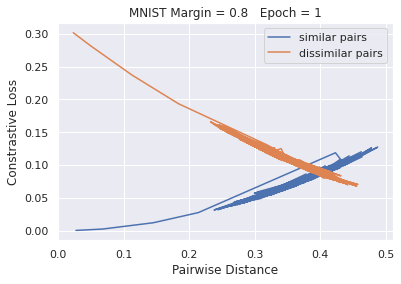

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diff

Epoch :  2 Batch :  0 loss :  0.0907173827290535
Epoch :  2 Batch :  100 loss :  0.08148735016584396
Epoch :  2 Batch :  200 loss :  0.08667256683111191
Epoch :  2 Batch :  300 loss :  0.08495192229747772
Epoch :  2 Batch :  400 loss :  0.085267573595047
Epoch :  2 Batch :  500 loss :  0.07799465954303741
Epoch :  2 Batch :  600 loss :  0.09313992410898209
Epoch :  2 Batch :  700 loss :  0.08122274279594421


In [0]:
import torch.nn.functional as F
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from argparse import ArgumentParser
import seaborn as sns; sns.set()
import torch.nn  as nn
from PIL import Image


parser = ArgumentParser(description='Simase Network ')
parser.add_argument('--learning_batch_size', type=int, default=64)
parser.add_argument('--constractive_loss_margin', type=float, default=0.8)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=2)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')


args, unknown = parser.parse_known_args()

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'


import torch.nn as nn

class SimaseNet(nn.Module):

    def __init__(self):
        super(SimaseNet,self).__init__()

        self.conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(in_channels=32,out_channels=64, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2)
                                  )
        #output 64,4,4

        self.fc = nn. Sequential(nn.Linear(64*4*4,256),
                                 nn.ReLU(),
                                 nn.Linear(256,256),
                                 nn.ReLU(),
                                 nn.Linear(256,16)
                                 )

    def forward_once(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, in1, in2):
        out1 = self.forward_once(in1)
        out2 = self.forward_once(in2)
        return out1, out2



class SiameseMNIST(Dataset):

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)


            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               0]
                              for i in range(0, len(self.test_data), 2)]
            #print(positive_pairs)

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               1]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs


    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):

        if self.train:
            target = np.random.randint(0, 2) #0,1
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1: #similar ones
                siamese_index = index
                while siamese_index == index:
                        siamese_index = np.random.choice(self.label_to_indices[label1])  # Random


            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]

        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy())
        img2 = Image.fromarray(img2.numpy())

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, target



pwd_similiar = np.array([])
loss_similar = np.array([])

pwd_dis = np.array([])
loss_dis = np.array([])

class ContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin


    def forward(self, output, target):

  
        eq_distance = F.pairwise_distance(output[0], output[1]) 
        np_target = target.numpy()
        np_distance = eq_distance.detach().numpy()
       
        global pwd_similiar, pwd_dis, loss_similar, loss_dis

        pwd_similiar = np.append(pwd_similiar, np.mean(np_distance[[np.where(np_target == 0)]]))
        pwd_dis = np.append(pwd_dis, np.mean(np_distance[[np.where(np_target == 1)]]))

        loss = 0.5 * (1 - target.float()) * torch.pow(eq_distance, 2) + \
               0.5 * target.float() * torch.pow(torch.clamp(self.margin - eq_distance, min=0.00), 2)
        np_loss = loss.detach().numpy()

        loss_similar = np.append(loss_similar, np.mean(np_loss[[np.where(np_target == 0)]]))
        loss_dis = np.append(loss_dis, np.mean(np_loss[[np.where(np_target == 1)]]))

        #print('shape ', ' similar distances', len(pwd_similiar),len(loss_similar))
        #print('shape ', ' dis distances', len(pwd_dis), len(loss_dis))

        return loss.mean()
       

def draw_plot(epoch):
    global pwd_similiar, pwd_dis,loss_similar,loss_dis
    plt.plot(pwd_similiar, loss_similar, label="similar pairs")
    plt.plot(pwd_dis, loss_dis, label="dissimilar pairs")
    plt.xlabel('Pairwise Distance')
    plt.ylabel('Constrastive Loss')
    title = "MNIST Margin = {}   Epoch = {}".format(args.constractive_loss_margin,epoch)
    plt.title(title)
    plt.legend()
    plt.show()

    pwd_similiar = np.array([])
    loss_similar = np.array([])
    pwd_dis = np.array([])
    loss_dis = np.array([])


train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform = transforms.Compose([
                                 transforms.ToTensor()
                             ]))

test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

siamese_train_dataset = SiameseMNIST(train_dataset)
split = int(np.floor(args.validation_split * len(siamese_train_dataset)))
indices = list(range(len(siamese_train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size = args.learning_batch_size,
                                                   sampler=train_sampler)
siamese_val_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size = args.learning_batch_size,
                                                  sampler=valid_sampler)

simase_test_dataset = SiameseMNIST(test_dataset)
siamese_test_loader = torch.utils.data.DataLoader(simase_test_dataset, batch_size = 1, shuffle=True)


model = SimaseNet()
model = model.to(DEVICE)
criterion = ContrastiveLoss(margin=args.constractive_loss_margin)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

train = True

if train:
    # training
    model.train()
    losses = []
    chunk = 100

    for epoch in range(1, args.num_epochs+1):

        for batch_idx, batch in enumerate(siamese_train_loader):

            img1, img2, target = batch
            img1 = img1.to(DEVICE)
            img2 = img2.to(DEVICE)
            optimizer.zero_grad()
            out1, out2 = model(img1, img2)
            out = [out1.cpu(), out2.cpu()]
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            if batch_idx % chunk == 0:
              print("Epoch : ", epoch, "Batch : " , batch_idx, "loss : ", loss.item())
            losses.append(loss.item())

        print("Epoch", epoch, "loss ", np.mean(losses))
        draw_plot(epoch)

    torch.save(model, 'simase.pth')

if not train:

        model = torch.load('simase.pth')
        model.eval()

        lss = []
        lds = []

        for batch_idx, data in enumerate(siamese_test_loader):
            img1, img2, target = data
            out1, out2 = model(img1, img2)
            eq = F.pairwise_distance(out1,out2)
            print(eq)

            #same =0
            if target == 0 :
                loss = criterion(out1, out2, target)
                print('loss',loss)
                lss.append(loss)
            else:
                loss = criterion(out1, out2, target)
                lds.append(loss)






